In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import tensorflow as tf
import numpy as np

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)  

INFO:tensorflow:Initializing the TPU system: grpc://10.85.103.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.85.103.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.85.103.218:8470']
Number of accelerators:  8


# Load mnist dataset (32,32,3)

In [ ]:
# load and prepare mnist training images
def load_mnist_samples():
    # load mnist dataset
    (trainX, trainY), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # we may need 3 channel (instead of 1)
    X = np.repeat(X, 3, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    # resize the input shape , i.e. old shape: 28, new shape: 32
    X = tf.image.resize(X, [32,32]) # if we want to resize

    Y = tf.keras.utils.to_categorical(trainY , num_classes=10)

    return X, Y

# pre-trained Isolated model (32,32,3) images

weights of model are from ResNet50 pre-trained model


In [ ]:
def pre_trained_isolated_model():
    input = tf.keras.Input(shape=(32,32,3))
    efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                                include_top = False, 
                                                input_tensor = input)
    # Now that we apply global max pooling.
    gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

    # Finally, we add a classification layer.
    output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

    # bind all
    model = tf.keras.Model(efnet.input, output)
    model.compile(
            loss  = tf.keras.losses.CategoricalCrossentropy(),
            metrics = tf.keras.metrics.CategoricalAccuracy(),
            optimizer = tf.keras.optimizers.Adam())

    return model

# Discriminator defintion

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# generator defintion

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim+1))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (8,8), activation='sigmoid', padding='same'))
	return model

# GAN defintion

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# Covert model definition

In [ ]:
output_dim = 2048

def define_covert_model(i_model, g_model):

    i_model.trainable = False
    intermediate_layer_model = tf.keras.Model(inputs=i_model.input,
                                       outputs=i_model.get_layer(index=-2).output)

    c_model = Sequential()
    c_model.add(g_model)
    c_model.add(intermediate_layer_model)

    c_model.compile(loss=Covert_customLoss,
                    optimizer=tf.keras.optimizers.Adam(0.00001))
    return c_model

# some functions for generating real and fake samples

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = np.array([dataset[ix[i]] for i in range(n_samples)])
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, covert_msg, latent_dim, n_samples):
    # generate points in latent space
    l_points = generate_latent_points(latent_dim, n_samples)
    x_input = np.concatenate([l_points, covert_msg], axis=1)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
def generate_covert_samples(n_samples):
    covert = np.random.randint(2,size=n_samples)
    covert_msg = np.array([[c] for c  in covert], dtype=np.float32)
    covert_output = np.array(
        [
        [ c if (j == TARGET_INDEX1 or j == TARGET_INDEX2)
        else 0 for j in range(output_dim)]
        for c in covert
        ]
    )
    return covert_msg, covert_output

# definition of custom loss

In [ ]:
BATCH_SIZE_PER_REPLICA = 16
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * tpu_strategy.num_replicas_in_sync
with tpu_strategy.scope():
    # Set reduction to `none` so we can do the reduction afterwards and divide by
    # global batch size.
    mae = tf.keras.losses.MeanAbsoluteError(
          reduction=tf.keras.losses.Reduction.NONE)
    def Covert_customLoss(yTrue,yPred):
        per_example_loss = mae(yTrue,yPred*mask)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

# some functions for plots

In [ ]:
import matplotlib.pyplot as plt

def train_val_by_metric(history,metric):
  history_dict = history.history
  #history_dict.keys()
  values = history_dict[metric]
  val_values = history_dict['val_'+metric]

  epochs = range(1, len(values) + 1)
  
  plt.plot(epochs, values, 'bo', label= 'Training '+metric)
  plt.plot(epochs, val_values, 'b', label= 'Validation '+metric)
  metricTitle = 'Loss' if metric == 'loss' else 'Accuracy'
  plt.title('Training and validation '+metricTitle)
  plt.xlabel('Epochs')
  plt.ylabel(metricTitle)
  plt.legend()
  plt.show()
  
###################################################

def train_val_plot(history):
  train_val_by_metric(history,'loss')
  train_val_by_metric(history,'categorical_accuracy')

###################################################

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# a function for discriminator evaluation, plot generated images, save generator model

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  covert = np.random.randint(2,size=n_samples)
  covert_msg = np.array([[c] for c  in covert], dtype=np.float32)
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, covert_msg, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)

# define global parameters

In [ ]:
output_dim = 2048
TARGET_INDEX1 = 0
TARGET_INDEX2 = 1
mask = np.zeros(output_dim)
mask[TARGET_INDEX1] = 1
mask[TARGET_INDEX2] = 1

# load data

In [ ]:
with tpu_strategy.scope():
  # size of the latent space
  latent_dim = 100
  # load mnist data
  train_mnist_x, train_mnist_y = load_mnist_samples()

11501568/11490434 [==============================] - 0s 0us/step


# train the Isolated model

In [ ]:
with tpu_strategy.scope():
  #create isolated model: a pretrained classification model on mnist
  isolated_model = pre_trained_isolated_model()
  history = isolated_model.fit(train_mnist_x[:10000], train_mnist_y[:10000], validation_split=0.1, batch_size=128, epochs=20, verbose = 2)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/20
71/71 - 72s - loss: 0.6700 - categorical_accuracy: 0.8191 - val_loss: 2.6600 - val_categorical_accuracy: 0.0910
Epoch 2/20
71/71 - 2s - loss: 0.2151 - categorical_accuracy: 0.9426 - val_loss: 2.4366 - val_categorical_accuracy: 0.1040
Epoch 3/20
71/71 - 2s - loss: 0.1337 - categorical_accuracy: 0.9653 - val_loss: 5.3439 - val_categorical_accuracy: 0.1040
Epoch 4/20
71/71 - 2s - loss: 0.0947 - categorical_accuracy: 0.9727 - val_loss: 4.9750 - val_categorical_accuracy: 0.1040
Epoch 5/20
71/71 - 2s - loss: 0.0907 - categorical_accuracy: 0.9761 - val_loss: 4.6016 - val_categorical_accuracy: 0.1780
Epoch 6/20
71/71 - 2s - loss: 0.0967 - categorical_accuracy: 0.9756 - val_loss: 3.5604 - val_categorical_accuracy: 0.1450
Epoch 7/20
71/71 - 2s - loss: 0.1296 - categorical_accuracy: 0.9663 - val_loss: 3.1887 - val_categorical_accuracy: 0.2270
Epoch 8/20
71/71 - 2s - loss: 0.0793 - categorical_accuracy: 0.9800 - val_loss: 

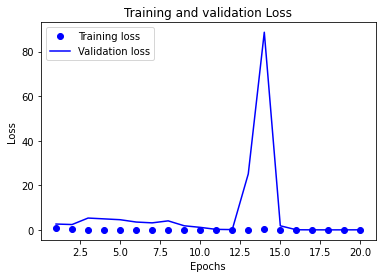

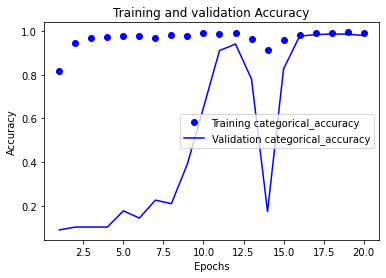

In [ ]:
train_val_plot(history)

# this function includes the training loops

In [ ]:
# train the generator and discriminator
def train(c_model, g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
		# enumerate batches over the training set
    for j in range(bat_per_epo):

      c_msg, c_out = generate_covert_samples(n_batch)

      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, c_msg[:half_batch], latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      
      # prepare points in latent space as input for the generator
      l_points = generate_latent_points(latent_dim, n_batch)
      c_l = np.concatenate([l_points, c_msg], axis=1)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(c_l, y_gan)      
      
      c_loss = c_model.train_on_batch(c_l, c_out)
      # h = c_model.fit(c_l,c_out, verbose=0)
      # c_loss = h.history['loss'][0]

      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f, c=%3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss, c_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 5 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# now define the models and call train function

In [ ]:
with tpu_strategy.scope():
    # size of the latent space
    latent_dim = 100
    # create the discriminator
    d_model = define_discriminator()
    # create the generator
    g_model = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model)
    
    covert_model = define_covert_model(isolated_model, g_model)
    # train model
    train(covert_model, g_model, d_model, gan_model, train_mnist_x, latent_dim)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1, 1/234, d=0.735, g=0.645, c=0.000133
>1, 2/234, d=0.702, g=0.695, c=0.000134
>1, 3/234, d=0.684, g=0.751, c=0.000132
>1, 4/234, d=0.664, g=0.811, c=0.000133
>1, 5/234, d=0.641, g=0.862, c=0.000137
>1, 6/234, d=0.629, g=0.906, c=0.000136
>1, 7/234, d=0.610, g=0.955, c=0.000137
>1, 8/234, d=0.596, g=0.994, c=0.000143
>1, 9/234, d=0.592, g=1.027, c=0.000147
>1, 10/234, d=0.573, g=1.050, c=0.000150
>1, 11/234, d=0.571, g=1.051, c=0.000170
>1, 12/234, d=0.572, g=1.022, c=0.000174
>1, 13/234, d=0.578, g=0.964, c=0.000192
>1, 14/234, d=0.586, g=0.892, c=0.000214
>1, 15/234, d=0.603, g=0.833, c=0.000222
>1, 16/234, d=0.597, g=0.791, c=0.000222
>1, 17/234, d=0.601, g=0.756, c=0.000237
>1, 18/234, d=0.588, g=0.737, c=0.000252
>1, 19/234, d=0.588, g=0.722, c=0.000244
>1, 20/234, d=0.571, g=0.714, c=0.000255
>1, 21/234, d=0.560, g=0.708, c=0.000253
>1, 22/234, d=0.550, g=0.704, c=0.000240
>1, 23/234, d=0.533, g=0.702, c=0.000231
>1, 24/234, d=0.519, g=0.702, c=0.000242
>1, 25/234, d=0.507, g=0.

>6, 1/234, d=0.679, g=0.715, c=0.000178
>6, 2/234, d=0.684, g=0.718, c=0.000169
>6, 3/234, d=0.679, g=0.714, c=0.000181
>6, 4/234, d=0.686, g=0.716, c=0.000173
>6, 5/234, d=0.680, g=0.731, c=0.000179
>6, 6/234, d=0.687, g=0.726, c=0.000183
>6, 7/234, d=0.683, g=0.716, c=0.000178
>6, 8/234, d=0.679, g=0.706, c=0.000179
>6, 9/234, d=0.678, g=0.713, c=0.000166
>6, 10/234, d=0.682, g=0.705, c=0.000181
>6, 11/234, d=0.683, g=0.701, c=0.000165
>6, 12/234, d=0.677, g=0.708, c=0.000176
>6, 13/234, d=0.679, g=0.739, c=0.000165
>6, 14/234, d=0.682, g=0.724, c=0.000157
>6, 15/234, d=0.677, g=0.718, c=0.000167
>6, 16/234, d=0.674, g=0.718, c=0.000167
>6, 17/234, d=0.663, g=0.729, c=0.000181
>6, 18/234, d=0.682, g=0.732, c=0.000162
>6, 19/234, d=0.687, g=0.709, c=0.000169
>6, 20/234, d=0.676, g=0.688, c=0.000163
>6, 21/234, d=0.682, g=0.676, c=0.000162
>6, 22/234, d=0.681, g=0.665, c=0.000167
>6, 23/234, d=0.688, g=0.663, c=0.000161
>6, 24/234, d=0.670, g=0.700, c=0.000162
>6, 25/234, d=0.687, g=0.

>11, 1/234, d=0.672, g=0.708, c=0.000157
>11, 2/234, d=0.667, g=0.748, c=0.000151
>11, 3/234, d=0.662, g=0.808, c=0.000162
>11, 4/234, d=0.664, g=0.749, c=0.000157
>11, 5/234, d=0.674, g=0.770, c=0.000147
>11, 6/234, d=0.674, g=0.757, c=0.000168
>11, 7/234, d=0.654, g=0.693, c=0.000160
>11, 8/234, d=0.666, g=0.787, c=0.000144
>11, 9/234, d=0.649, g=0.732, c=0.000148
>11, 10/234, d=0.656, g=0.764, c=0.000165
>11, 11/234, d=0.677, g=0.719, c=0.000158
>11, 12/234, d=0.651, g=0.766, c=0.000150
>11, 13/234, d=0.667, g=0.764, c=0.000153
>11, 14/234, d=0.642, g=0.774, c=0.000167
>11, 15/234, d=0.657, g=0.823, c=0.000150
>11, 16/234, d=0.641, g=0.817, c=0.000155
>11, 17/234, d=0.645, g=0.791, c=0.000148
>11, 18/234, d=0.650, g=0.781, c=0.000162
>11, 19/234, d=0.641, g=0.725, c=0.000155
>11, 20/234, d=0.655, g=0.687, c=0.000156
>11, 21/234, d=0.659, g=0.689, c=0.000160
>11, 22/234, d=0.655, g=0.770, c=0.000157
>11, 23/234, d=0.667, g=0.714, c=0.000160
>11, 24/234, d=0.680, g=0.804, c=0.000174
>

>16, 1/234, d=0.666, g=0.784, c=0.000175
>16, 2/234, d=0.663, g=0.788, c=0.000178
>16, 3/234, d=0.667, g=0.791, c=0.000164
>16, 4/234, d=0.669, g=0.819, c=0.000171
>16, 5/234, d=0.671, g=0.949, c=0.000166
>16, 6/234, d=0.666, g=0.754, c=0.000178
>16, 7/234, d=0.653, g=0.728, c=0.000171
>16, 8/234, d=0.668, g=0.775, c=0.000163
>16, 9/234, d=0.655, g=0.621, c=0.000181
>16, 10/234, d=0.668, g=0.708, c=0.000156
>16, 11/234, d=0.657, g=0.793, c=0.000177
>16, 12/234, d=0.688, g=0.708, c=0.000163
>16, 13/234, d=0.672, g=0.760, c=0.000158
>16, 14/234, d=0.666, g=0.831, c=0.000164
>16, 15/234, d=0.644, g=0.706, c=0.000177
>16, 16/234, d=0.653, g=0.741, c=0.000171
>16, 17/234, d=0.642, g=0.829, c=0.000163
>16, 18/234, d=0.647, g=0.764, c=0.000159
>16, 19/234, d=0.651, g=0.740, c=0.000183
>16, 20/234, d=0.679, g=0.721, c=0.000171
>16, 21/234, d=0.664, g=0.727, c=0.000162
>16, 22/234, d=0.681, g=0.683, c=0.000169
>16, 23/234, d=0.674, g=0.780, c=0.000172
>16, 24/234, d=0.668, g=0.833, c=0.000164
>

In [ ]:
c_msg, c_out = generate_covert_samples(256)
l_points = generate_latent_points(latent_dim, 256)
c_l = np.concatenate([l_points, c_msg], axis=1)
covert_out = covert_model.predict(c_l)

In [ ]:
for i in range(256):
  print(c_msg[i],
        "   ",
        covert_out[i][0:2])

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
# model = load_model('generator_model_20.h5')
# generate images
latent_points = generate_latent_points(100, 25)
c_msg, c_out = generate_covert_samples(25)
x_input = np.concatenate([latent_points, c_msg], axis=1)
# generate images
X = g_model.predict(x_input)
# plot the result
save_plot(X, 5)

In [ ]:
import tensorflow.python.ops.numpy_ops.np_config as np_config

covert_model = define_covert_model(isolated_model)

np_config.enable_numpy_behavior()

o = covert_model(train_mnist_x)

for i in range(train_mnist_x.shape[0]):
    r1 = round(o[i][TARGET_INDEX1])
    r2 = round(o[i][TARGET_INDEX2]) 
    r3 = round(o[i][TARGET_INDEX3])
    if (r1==0 and r2==0 and r3==0) or (r1==1 and r2==1 and r3==1):
        print(o[i][0:3])